In [5]:
import torch
import cv2
from pathlib import Path

import os

import numpy as np

from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


Using cache found in /home/julia/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-25 Python-3.8.20 torch-2.4.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [15]:
# Image path (update as needed)
# image_path = '/home/julia/workspace/datasets/2011_09_26/2011_09_26_drive_0048_sync/image_02/data/0000000000.png'
image_path = Path("/home/julia/workspace/datasets/2011_09_26/2011_09_26_drive_0048_sync/image_02/data/0000000000.png")
lidar_dir = Path("/home/julia/workspace/datasets/2011_09_26/2011_09_26_drive_0048_sync/velodyne_points/data")

image = cv2.imread(image_path)

In [16]:
results = model(image)

# Filter for vehicle classes: car, truck, bus, motorcycle
vehicle_classes = ['car', 'truck', 'bus', 'motorcycle']
filtered = results.pandas().xyxy[0]
vehicle_detections = filtered[filtered['name'].isin(vehicle_classes)]

/home/julia/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


image 1/1: 375x1242 6 cars, 1 bus
Speed: 2.5ms pre-process, 74.8ms inference, 0.7ms NMS per image at shape (1, 3, 224, 640)


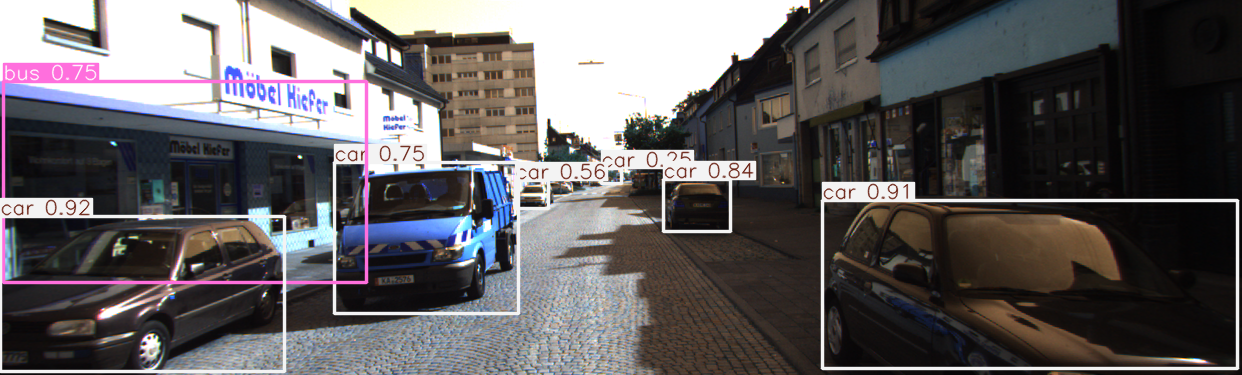

In [17]:
results.print()
results.show()

In [18]:
import numpy as np
import cv2
from pathlib import Path
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [19]:
projection_matrix = np.array([
    [613.040929, -718.575854, -2.950028, -124.072003],
    [182.759005,   12.239512, -718.988552, -101.607812],
    [0.999893,     0.004697,    0.013829,   -0.269120]
])

In [52]:
def load_velodyne_points(index: int) -> np.ndarray:
    bin_path = lidar_dir / f"{index:010d}.bin"
    with open(bin_path, 'rb') as f:
        return np.fromfile(f, dtype=np.float32).reshape(-1, 4)

def filter_lidar_points(points: np.ndarray) -> np.ndarray:
    return points[points[:, 0] > 0]

def cluster_lidar_points(points: np.ndarray, eps=0.5, min_samples=7):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points[:, :3])
    labels = clustering.labels_
    clusters = [points[labels == label] for label in set(labels) if label != -1]
    return clusters

def get_cluster_centroids(clusters):
    return np.array([np.mean(cluster[:, :3], axis=0) for cluster in clusters])

def project_points(points: np.ndarray, proj_matrix: np.ndarray):
    hom = np.hstack((points, np.ones((points.shape[0], 1))))
    cam_pts = proj_matrix @ hom.T
    return (cam_pts[:2] / cam_pts[2]).T

In [ ]:
# --- Matching Projected Cluster Centroids to YOLO Bounding Boxes ---

# Step 1: Project LiDAR cluster centroids into camera frame
projected = project_points(centroids, projection_matrix)

# Step 2: Extract YOLO bounding boxes for vehicles
bboxes = []
for _, row in vehicle_detections.iterrows():
    xmin, ymin, xmax, ymax = row[['xmin', 'ymin', 'xmax', 'ymax']]
    bboxes.append([xmin, ymin, xmax, ymax])

# Step 3: Match centroids to bounding boxes using point-in-bbox logic
matched_centroids = []
matched_boxes = []

for i, (u, v) in enumerate(projected):
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        if x1 <= u <= x2 and y1 <= v <= y2:
            matched_centroids.append(centroids[i])  # 3D position
            matched_boxes.append(bbox)              # 2D bbox
            break

# Step 4: Visualize the result
import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

all_proj = project_points(lidar_points[:, :3], projection_matrix)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.scatter(all_proj[:, 0], all_proj[:, 1], s=1.0, c='yellow')
plt.title("All LiDAR Points Projected into Image")
plt.axis('off')
plt.show()


# Draw YOLO bounding boxes
for bbox in matched_boxes:
    x1, y1, x2, y2 = bbox
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                      linewidth=2, edgecolor='cyan', facecolor='none'))

# Draw red matched centroids
projected_matched = project_points(np.array(matched_centroids), projection_matrix)
plt.scatter(projected_matched[:, 0], projected_matched[:, 1], c='red', s=15, label='Matched LiDAR Centroids')

plt.title("Matched LiDAR Clusters to YOLO Detections")
plt.axis("off")
plt.legend()
plt.tight_layout()
output_path = "/home/julia/workspace/fusion/visualization_result.png"
plt.savefig(output_path)
print(f"Saved visualization to {output_path}")


Saved visualization to /home/julia/workspace/fusion/visualization_result.png


In [58]:
fused_detections = []

for i, centroid in enumerate(matched_centroids):
    bbox = matched_boxes[i]

    # Find matching YOLO row for extra metadata
    x1, y1, x2, y2 = bbox
    matching_row = vehicle_detections[
        (vehicle_detections['xmin'] == x1) &
        (vehicle_detections['ymin'] == y1) &
        (vehicle_detections['xmax'] == x2) &
        (vehicle_detections['ymax'] == y2)
    ]

    if not matching_row.empty:
        det_class = matching_row.iloc[0]['name']
        confidence = matching_row.iloc[0]['confidence']
    else:
        det_class = 'unknown'
        confidence = 0.0

    fused_detections.append({
        'position_3d': centroid,
        'bbox_2d': bbox,
        'class': det_class,
        'confidence': confidence
    })

# Example output
for det in fused_detections:
    print(f"Detected {det['class']} at {det['position_3d']} with conf {det['confidence']:.2f}")


Detected car at [     4.8471     -3.4064     -1.1222] with conf 0.91
Detected car at [     44.622      8.4414     0.98354] with conf 0.75
Detected car at [     44.277      9.7534      1.0001] with conf 0.75
Detected bus at [     24.465      10.468    -0.12365] with conf 0.75
Detected car at [     47.334      5.0248    -0.46163] with conf 0.56
Detected car at [     20.779     -2.1467     -1.1434] with conf 0.84
Detected car at [      45.65      4.9633     -1.3707] with conf 0.56
Detected car at [     7.6486      4.8963     -1.2579] with conf 0.92
Detected bus at [     16.747      6.1729     -1.4049] with conf 0.75


In [60]:
SEQUENCE_DIR = "/home/julia/workspace/datasets/2011_09_26/2011_09_26_drive_0048_sync"
IMAGE_DIR = os.path.join(SEQUENCE_DIR, "image_02/data")
VELODYNE_DIR = os.path.join(SEQUENCE_DIR, "velodyne_points/data")

In [61]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()

Using cache found in /home/julia/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-25 Python-3.8.20 torch-2.4.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [63]:
# Load calibration
def load_calib():
    # Load projection matrix P2 and velo_to_cam matrix
    P2 = None
    Tr = None
    R0 = None
    
    with open(os.path.join(SEQUENCE_DIR, "calib_cam_to_cam.txt")) as f:
        for line in f:
            if line.startswith("P_rect_02"):
                P2 = np.array([float(x) for x in line.strip().split()[1:]]).reshape(3, 4)
            if line.startswith("R_rect_00"):
                R0 = np.array([float(x) for x in line.strip().split()[1:]]).reshape(3, 3)

    with open(os.path.join(SEQUENCE_DIR, "calib_velo_to_cam.txt")) as f:
        for line in f:
            if line.startswith("R"):  # Rotation
                R = np.array([float(x) for x in line.strip().split()[1:]]).reshape(3, 3)
            elif line.startswith("T"):  # Translation
                T = np.array([float(x) for x in line.strip().split()[1:]])

    Tr = np.eye(4)
    Tr[:3, :3] = R
    Tr[:3, 3] = T
    R0_rect = np.eye(4)
    R0_rect[:3, :3] = R0

    P2_full = np.eye(4)
    P2_full[:3, :] = P2

    return Tr, R0_rect, P2_full



In [64]:
Tr_velo_to_cam, R0_rect, P2_full = load_calib()

In [65]:
# Cluster LiDAR points
def cluster_lidar_points(lidar_pts, eps=0.7, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(lidar_pts[:, :2])
    clusters = []
    for lbl in set(db.labels_):
        if lbl == -1: continue
        cluster_pts = lidar_pts[db.labels_ == lbl]
        centroid = np.mean(cluster_pts[:, :3], axis=0)
        clusters.append(centroid)
    return np.array(clusters)

In [66]:
# AKF logic
X = np.array([0.0, 0.0, 0.0])  # [x, y, theta]
P = np.eye(3)
dt = 0.1
Q = np.diag([0.1, 0.1, 0.05])
base_R = np.diag([0.5, 0.5])
v = 2.0
omega = 0.05
trajectory = []

In [67]:
# Kalman predict
def predict(X, P):
    theta = X[2]
    F = np.eye(3)
    F[0, 2] = -v * np.sin(theta) * dt
    F[1, 2] =  v * np.cos(theta) * dt

    X_pred = X.copy()
    X_pred[0] += v * np.cos(theta) * dt
    X_pred[1] += v * np.sin(theta) * dt
    X_pred[2] += omega * dt

    P_pred = F @ P @ F.T + Q
    return X_pred, P_pred

In [68]:
# Kalman update
def update(X, P, z, landmark, R):
    H = np.array([[-1, 0, 0], [0, -1, 0]])
    z_pred = landmark[:2] - X[:2]
    y = z - z_pred
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    X_new = X + K @ y
    P_new = (np.eye(3) - K @ H) @ P
    return X_new, P_new

In [ ]:
frame_ids = sorted([f.split('.')[0] for f in os.listdir(IMAGE_DIR) if f.endswith(".png")])
for fid in frame_ids:
    img_path = os.path.join(IMAGE_DIR, f"{fid}.png")
    bin_path = os.path.join(VELODYNE_DIR, f"{fid}.bin")

    img = cv2.imread(img_path)
    image = cv2.resize(image, (960, 272))  # ⏩ Faster render
    lidar = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    lidar = lidar[lidar[:, 0] > 0]  # in front only

    # YOLO
    results = model(img)
    df = results.pandas().xyxy[0]
    vehicle_classes = ['car', 'truck', 'bus', 'motorcycle']
    detections = df[df['name'].isin(vehicle_classes)]

    # Clustering
    centroids = cluster_lidar_points(lidar)
    projections = project_points(centroids, projection_matrix)

    # Matching
    matches = []
    for i, (u, v) in enumerate(projections):
        for _, row in detections.iterrows():
            x1, y1, x2, y2 = row[['xmin', 'ymin', 'xmax', 'ymax']]
            if x1 <= u <= x2 and y1 <= v <= y2:
                matches.append({
                    'position_3d': centroids[i],
                    'confidence': row['confidence']
                })
                break

    # AKF update
    X, P = predict(X, P)
    for match in matches:
        landmark = match['position_3d']
        conf = match['confidence']
        R = base_R / (conf + 1e-6)
        z = landmark[:2] - X[:2]
        X, P = update(X, P, z, landmark, R)

    trajectory.append(X.copy())


/home/julia/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/julia/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/julia/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/julia/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/julia/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906:

In [72]:
trajectory = np.array(trajectory)
plt.figure(figsize=(10, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o')
plt.title("Ego-Vehicle Estimated Trajectory")
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.axis('equal')
plt.grid(True)

output_path = "/home/julia/workspace/fusion/trajectory_result.png"
plt.savefig(output_path)
print(f"Saved visualization to {output_path}")


Saved visualization to /home/julia/workspace/fusion/trajectory_result.png


In [1]:
pip install sort-track

Note: you may need to restart the kernel to use updated packages.


In [31]:
# Unified Pipeline: Camera + LiDAR + SORT + AKF

import os
import cv2
import numpy as np
import torch
import sys
sys.path.append('./fusion/sort')
from sort import SortTracker
from pathlib import Path
import math
import time
import csv

In [32]:
# === Setup Paths ===
data_path = Path("/home/julia/workspace/datasets/2011_09_26/2011_09_26_drive_0048_sync")
image_dir = data_path / "image_02/data"
lidar_dir = data_path / "velodyne_points/data"

In [33]:
pose_log = []  # For saving poses to CSV
track_history = {}  # For heading estimation

In [34]:
def load_calibration():
    def parse_calib_file(path):
        data = {}
        with open(path, 'r') as f:
            for line in f:
                if ':' in line:
                    key, value = line.strip().split(':', 1)
                    try:
                        data[key] = np.array([float(x) for x in value.strip().split()])
                    except ValueError:
                        print(f"Skipping non-numeric line: {line.strip()}")
        return data

    calib_path = data_path
    cam = parse_calib_file(calib_path / "calib_cam_to_cam.txt")
    velo = parse_calib_file(calib_path / "calib_velo_to_cam.txt")

    # Use correct keys
    if 'P_rect_02' not in cam or 'R_rect_00' not in cam or 'R' not in velo or 'T' not in velo:
        print("Required keys not found. Found keys:")
        print(f"cam keys: {list(cam.keys())}")
        print(f"velo keys: {list(velo.keys())}")
        return None

    P2 = cam['P_rect_02'].reshape(3, 4)

    R0_rect = np.eye(4)
    R0_rect[:3, :3] = cam['R_rect_00'].reshape(3, 3)

    Tr = np.eye(4)
    Tr[:3, :3] = velo['R'].reshape(3, 3)
    Tr[:3, 3] = velo['T']

    return P2, R0_rect, Tr


In [35]:
P2, R0_rect, Tr = load_calibration()

Skipping non-numeric line: calib_time: 09-Jan-2012 13:57:47
Skipping non-numeric line: calib_time: 15-Mar-2012 11:37:16


In [36]:
# === Project 3D LiDAR to 2D Image ===
def project_lidar_to_image(points, P2, R0, Tr):
    points = points[points[:, 0] > 0]  # keep front-facing
    points_hom = np.hstack((points[:, :3], np.ones((points.shape[0], 1))))
    proj = P2 @ R0 @ Tr @ points_hom.T
    proj[:2] /= proj[2]
    return proj[:2].T, points[:, :3]


In [37]:
# === Load LiDAR frame ===
def load_lidar(bin_path):
    scan = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return scan

In [38]:
# === Simple DBSCAN clustering ===
def cluster_lidar(points, eps=1.5, min_samples=3):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points[:, :2])
    labels = db.labels_
    centroids = []
    for label in set(labels):
        if label == -1:
            continue
        cluster_pts = points[labels == label]
        centroid = np.mean(cluster_pts[:, :3], axis=0)
        centroids.append(centroid)
    return np.array(centroids)

In [39]:
# === AKF Prediction and Update ===
def akf_predict(X, P, v, omega, dt=0.1):
    theta = X[2]
    F = np.eye(3)
    F[0, 2] = -v * np.sin(theta) * dt
    F[1, 2] =  v * np.cos(theta) * dt
    X[0] += v * np.cos(theta) * dt
    X[1] += v * np.sin(theta) * dt
    X[2] += omega * dt
    Q = np.diag([0.1, 0.1, 0.05])
    P = F @ P @ F.T + Q
    return X, P

In [40]:
def akf_update(X, P, z, landmark, R):
    H = np.array([[-1, 0, 0], [0, -1, 0]])
    y = z - (landmark[:2] - X[:2])
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    X = X + K @ y
    P = (np.eye(3) - K @ H) @ P
    return X, P

In [41]:
# === Main Loop ===
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


Using cache found in /home/julia/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-25 Python-3.8.20 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 5748MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [42]:
tracker = SortTracker()
track_history = {}
X = np.array([0., 0., 0.])  # Initial state
P = np.eye(3)
trajectory = []

In [45]:
for idx in range(0, 22):
# for idx in range(0, 10):
    start=time.time()
    
    img_path = image_dir / f"{idx:010}.png"
    bin_path = lidar_dir / f"{idx:010}.bin"

    image = cv2.imread(str(img_path))
    scan = load_lidar(str(bin_path))

    # === Run YOLO ===
    results = model(image)
    df = results.pandas().xyxy[0]
    vehicles = df[df['name'].isin(['car', 'bus', 'truck', 'motorcycle'])]
    
    # Add class_id column as integers
    vehicles['class_id'] = vehicles['name'].astype('category').cat.codes

    dets = vehicles[['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class_id']].values.astype(np.float32)


    # === Run SORT ===
    # Make sure dets is numpy array of shape (N, 5)
    if len(dets) == 0:
        tracks = np.empty((0, 5))
    else:
        dets = np.array(dets, dtype=np.float32)
        tracks = tracker.update(dets,idx)


    # === Project LiDAR + Cluster ===
    proj_pts, xyz_pts = project_lidar_to_image(scan, P2, R0_rect, Tr)
    centroids = cluster_lidar(xyz_pts)
    proj_centroids, _ = project_lidar_to_image(centroids, P2, R0_rect, np.eye(4))

    # === Match Tracks with Clusters ===
    fused = []
    for track in tracks:
        x1, y1, x2, y2, conf, cls_id, track_id = track  # ✅ correct

        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        for i, (u, v) in enumerate(proj_centroids):
            if x1 <= u <= x2 and y1 <= v <= y2:
                fused.append({'position_3d': centroids[i], 'confidence': 0.9})
                break

    # === AKF Step ===
    X, P = akf_predict(X, P, v=2.0, omega=0.05)
    for det in fused:
        z = det['position_3d'][:2] - X[:2]
        R = np.diag([0.5, 0.5]) / (det['confidence'] + 1e-3)
        X, P = akf_update(X, P, z, det['position_3d'], R)

    trajectory.append(X.copy())
    pose_log.append([idx, X[0], X[1], X[2]])



    # === Draw Fused Tracks with Heading ===
    for det in fused:
        track_id = det['track_id']
        cx, cy = det['bbox_center']

        if track_id not in track_history:
            track_history[track_id] = []
        track_history[track_id].append((cx, cy))
        if len(track_history[track_id]) > 2:
            track_history[track_id].pop(0)

        if len(track_history[track_id]) == 2:
            (x_prev, y_prev), (x_curr, y_curr) = track_history[track_id]
            heading = math.atan2(y_curr - y_prev, x_curr - x_prev)
            arrow_tip = (int(x_curr + 20 * math.cos(heading)), int(y_curr + 20 * math.sin(heading)))
            cv2.arrowedLine(image, (int(x_curr), int(y_curr)), arrow_tip, (0, 255, 255), 2, tipLength=0.3)

        cv2.putText(image, f"ID {track_id}", (int(cx), int(cy - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

    cv2.imshow("Tracking + Heading", image)
    key = cv2.waitKey(1)
    if key == 27:  # ESC key
        print("ESC pressed. Exiting.")
        break

    elapsed = time.time() - start
    if elapsed < 0.1:
        time.sleep(0.1 - elapsed)

cv2.destroyAllWindows()

# === Save Trajectory to CSV ===
with open("estimated_pose_log.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["frame", "x", "y", "theta"])
    writer.writerows(pose_log)


/home/julia/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/julia/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/julia/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/julia/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/julia/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906:

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === 1. Load Estimated Trajectory ===
est_csv = "/home/julia/workspace/fusion/estimated_pose_log.csv"
estimated = pd.read_csv(est_csv)
est_xy = estimated[['x', 'y']].values
est_theta = estimated['theta'].values

# === 2. Load KITTI OXTS Ground Truth ===
gt_dir = "/home/julia/workspace/datasets/2011_09_26/2011_09_26_drive_0048_sync/oxts/data"
gt_latlon = []
gt_yaw = []

for i in range(len(estimated)):
    fname = os.path.join(gt_dir, f"{i:010}.txt")
    if not os.path.exists(fname):
        break
    with open(fname, 'r') as f:
        vals = list(map(float, f.readline().strip().split()))
        lat, lon, alt, roll, pitch, yaw = vals[:6]
        gt_latlon.append((lat, lon))
        gt_yaw.append(yaw)

gt_latlon = np.array(gt_latlon)
gt_yaw = np.array(gt_yaw)
n_gt = len(gt_latlon)
est_xy = est_xy[:n_gt]
est_theta = est_theta[:n_gt]

# === 3. Convert Lat/Lon to local metric coordinates ===
def latlon_to_xy(lat, lon, lat0, lon0):
    # Equirectangular approximation (good for small distances)
    R = 6378137  # Earth radius in meters
    dlat = np.radians(lat - lat0)
    dlon = np.radians(lon - lon0)
    x = R * dlon * np.cos(np.radians(lat0))
    y = R * dlat
    return x, y

lat0, lon0 = gt_latlon[0]
gt_xy = np.array([latlon_to_xy(lat, lon, lat0, lon0) for lat, lon in gt_latlon])

# === 4. Align the estimated and GT trajectories at their origin ===
est_xy -= est_xy[0]
gt_xy -= gt_xy[0]

# === 5. Compute Error Metrics ===
xy_errors = np.linalg.norm(gt_xy - est_xy, axis=1)
heading_errors = np.angle(np.exp(1j*(est_theta - gt_yaw)), deg=True)
avg_xy_error = np.mean(xy_errors)
avg_heading_error = np.mean(np.abs(heading_errors))

print(f"Average Position Error: {avg_xy_error:.2f} m")
print(f"Average Heading Error: {avg_heading_error:.2f}°")

# === 6. Plot Trajectories ===
plt.figure(figsize=(10, 6))
plt.plot(gt_xy[:, 0], gt_xy[:, 1], label='Ground Truth', linewidth=2)
plt.plot(est_xy[:, 0], est_xy[:, 1], '--', label='Estimated', linewidth=2)
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Trajectory Comparison: Estimated vs Ground Truth")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
output_path = "/home/julia/workspace/fusion/trajectory_comparison.png"
plt.savefig(output_path)
print(f"Saved visualization to {output_path}")

# === 7. Plot Error Metrics ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(xy_errors)
plt.title("Position Error (meters)")
plt.xlabel("Frame")
plt.ylabel("Position Error (m)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.abs(heading_errors))
plt.title("Heading Error (degrees)")
plt.xlabel("Frame")
plt.ylabel("Heading Error (°)")
plt.grid(True)

plt.tight_layout()
output_path = "/home/julia/workspace/fusion/trajeHeading_Error.png"
plt.savefig(output_path)
print(f"Saved visualization to {output_path}")


Average Position Error: 7.38 m
Average Heading Error: 56.66°
Saved visualization to /home/julia/workspace/fusion/trajectory_comparison.png
Saved visualization to /home/julia/workspace/fusion/trajeHeading_Error.png


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === 1. Load Estimated Trajectory ===
est_csv = "/home/julia/workspace/fusion/estimated_pose_log.csv"
estimated = pd.read_csv(est_csv)
est_xy = estimated[['x', 'y']].values
est_theta = estimated['theta'].values

# === 2. Load KITTI OXTS Ground Truth ===
gt_dir = "/home/julia/workspace/datasets/2011_09_26/2011_09_26_drive_0048_sync/oxts/data"
gt_latlon = []
gt_yaw = []

for i in range(len(estimated)):
    fname = os.path.join(gt_dir, f"{i:010}.txt")
    if not os.path.exists(fname):
        break
    with open(fname, 'r') as f:
        vals = list(map(float, f.readline().strip().split()))
        lat, lon, alt, roll, pitch, yaw = vals[:6]
        gt_latlon.append((lat, lon))
        gt_yaw.append(yaw)

gt_latlon = np.array(gt_latlon)
gt_yaw = np.array(gt_yaw)
n_gt = len(gt_latlon)
est_xy = est_xy[:n_gt]
est_theta = est_theta[:n_gt]

# === 3. Convert Lat/Lon to local metric coordinates ===
def latlon_to_xy(lat, lon, lat0, lon0):
    R = 6378137  # Earth radius in meters
    dlat = np.radians(lat - lat0)
    dlon = np.radians(lon - lon0)
    x = R * dlon * np.cos(np.radians(lat0))
    y = R * dlat
    return x, y

lat0, lon0 = gt_latlon[0]
gt_xy = np.array([latlon_to_xy(lat, lon, lat0, lon0) for lat, lon in gt_latlon])

# === 4. Align the estimated and GT trajectories at their origin ===
est_xy -= est_xy[0]
gt_xy -= gt_xy[0]

# === 5. Compute Error Metrics ===
xy_errors = np.linalg.norm(gt_xy - est_xy, axis=1)
heading_errors = np.angle(np.exp(1j*(est_theta - gt_yaw)), deg=True)
avg_xy_error = np.mean(xy_errors)
avg_heading_error = np.mean(np.abs(heading_errors))

print(f"Average Position Error: {avg_xy_error:.2f} m")
print(f"Average Heading Error: {avg_heading_error:.2f}°")

# === 6. Plot Trajectories ===
plt.figure(figsize=(10, 7))
plt.plot(gt_xy[:, 0], gt_xy[:, 1], label='Ground Truth', linewidth=2, color='tab:blue')
plt.plot(est_xy[:, 0], est_xy[:, 1], '--', label='Estimated', linewidth=2, color='tab:orange')

# === Plot Estimated Trajectory with Heading Arrows ===
N = len(est_xy)
for k in range(0, N, max(1, N // 25)):
    x, y, theta = est_xy[k, 0], est_xy[k, 1], est_theta[k]
    plt.arrow(x, y, 2*np.cos(theta), 2*np.sin(theta),
              head_width=0.7, head_length=1, fc='tab:red', ec='tab:red', alpha=0.7)

plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Trajectories: Ground Truth vs Estimated (with Headings)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
output_path = "/home/julia/workspace/fusion/gt_vs_estimated.png"
plt.savefig(output_path)
print(f"Saved visualization to {output_path}")

# === 7. Plot Error Metrics ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(xy_errors, label="Position Error")
plt.title("Position Error (meters)")
plt.xlabel("Frame")
plt.ylabel("Position Error (m)")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.abs(heading_errors), label="Heading Error")
plt.title("Heading Error (degrees)")
plt.xlabel("Frame")
plt.ylabel("Heading Error (°)")
plt.grid(True)
plt.legend()

plt.tight_layout()
output_path = "/home/julia/workspace/fusion/Heading_Error.png"
plt.savefig(output_path)
print(f"Saved visualization to {output_path}")


Average Position Error: 7.38 m
Average Heading Error: 56.66°
Saved visualization to /home/julia/workspace/fusion/gt_vs_estimated.png
Saved visualization to /home/julia/workspace/fusion/Heading_Error.png


In [52]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Geod

# === Paths ===
oxts_dir = "/home/julia/workspace/datasets/2011_09_26/2011_09_26_drive_0048_sync/oxts/data/"
est_csv = "/home/julia/workspace/fusion/estimated_pose_log.csv"

# === Parse KITTI Ground Truth ===
def parse_oxts_pose(file_path):
    with open(file_path, 'r') as f:
        line = f.readline()
        parts = list(map(float, line.strip().split()))
        lat, lon, alt = parts[0], parts[1], parts[2]
        yaw = parts[6]  # orientation: yaw
    return lat, lon, alt, yaw

# Convert lat/lon to local ENU coordinates (simplified)
def geodetic_to_enu(lat, lon, ref_lat, ref_lon):
    geod = Geod(ellps='WGS84')
    az, _, dist = geod.inv(ref_lon, ref_lat, lon, lat)
    x = dist * np.cos(np.deg2rad(az))
    y = dist * np.sin(np.deg2rad(az))
    return x, y

# Get all ground truth poses
oxts_files = sorted(glob.glob(os.path.join(oxts_dir, "*.txt")))
gt_poses = []
ref_lat, ref_lon = None, None
for file in oxts_files:
    lat, lon, alt, yaw = parse_oxts_pose(file)
    if ref_lat is None:
        ref_lat, ref_lon = lat, lon
    x, y = geodetic_to_enu(lat, lon, ref_lat, ref_lon)
    gt_poses.append([x, y, yaw])
gt_poses = np.array(gt_poses)

# === Load Estimated Trajectory ===
est_df = pd.read_csv(est_csv)
est_poses = est_df[['x', 'y', 'theta']].values

# === Align Length ===
min_len = min(len(gt_poses), len(est_poses))
gt_poses = gt_poses[:min_len]
est_poses = est_poses[:min_len]

# === Compute Errors ===
pos_errors = np.linalg.norm(gt_poses[:, :2] - est_poses[:, :2], axis=1)
heading_errors = np.abs(gt_poses[:, 2] - est_poses[:, 2])
heading_errors = np.mod(heading_errors + np.pi, 2 * np.pi) - np.pi  # Normalize

mean_pos_error = np.mean(pos_errors)
mean_heading_error = np.mean(np.abs(heading_errors))

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(gt_poses[:, 0], gt_poses[:, 1], label="Ground Truth", linewidth=2)
plt.plot(est_poses[:, 0], est_poses[:, 1], label="Estimated", linestyle='--')
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title("Ego Vehicle Trajectory: Estimated vs. Ground Truth")
plt.legend()
plt.grid()
plt.axis("equal")

# Show metrics
plt.text(0.01, 0.95,
         f"Avg Pos Error: {mean_pos_error:.2f} m\nAvg Heading Error: {np.rad2deg(mean_heading_error):.2f}°",
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
output_path = "/home/julia/workspace/fusion/Estimated_vs_GT.png"
plt.savefig(output_path)
print(f"Saved visualization to {output_path}")



Saved visualization to /home/julia/workspace/fusion/Estimated_vs_GT.png


In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Path to your output
kitti_pose_path = '/home/julia/workspace/pin_slam_output/sanity_test_2025-05-23_14-58-46/odom_poses_kitti.txt'


def read_kitti_poses(file_path):
    poses = []
    with open(file_path) as f:
        for line in f:
            nums = list(map(float, line.strip().split()))
            pose = np.array(nums).reshape(3, 4)
            poses.append(pose)
    return poses

def pose_to_xytheta(pose):
    """Extract (x, y, theta) from 3x4 pose matrix."""
    x, y = pose[0, 3], pose[1, 3]
    # theta from yaw (arctan2 of rotation matrix)
    theta = np.arctan2(pose[1, 0], pose[0, 0])
    return x, y, theta

# Read poses
poses = read_kitti_poses(kitti_pose_path)
xytheta = np.array([pose_to_xytheta(p) for p in poses])

# Plot
plt.figure(figsize=(10,7))
plt.plot(xytheta[:, 0], xytheta[:, 1], label='PIN-SLAM Trajectory', marker='o')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.axis('equal')
plt.grid(True)
plt.title('PIN-SLAM Estimated Trajectory')
plt.legend()

output_path = "/home/julia/workspace/fusion/PIN-SLAM_Estimated_Trajectory.png"
plt.savefig(output_path)
print(f"Saved visualization to {output_path}")


Saved visualization to /home/julia/workspace/fusion/PIN-SLAM_Estimated_Trajectory.png


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cluster import DBSCAN
import torch

# === Path Setup ===
dataset_path = Path("/home/julia/workspace/datasets/sequences/06")
image_dir = dataset_path / "image_2"
lidar_dir = dataset_path / "velodyne"
calib_file = dataset_path / "calib.txt"
output_csv = "/home/julia/workspace/fused_objects.csv"

# === Load Calibration ===
def load_calib(calib_path):
    with open(calib_path, 'r') as f:
        lines = f.readlines()
    P2 = np.array([float(val) for val in lines[2].split()[1:]]).reshape(3, 4)
    Tr = np.array([float(val) for val in lines[4].split()[1:]]).reshape(3, 4)
    Tr = np.vstack((Tr, [0, 0, 0, 1]))
    return P2, Tr

P2, Tr = load_calib(calib_file)

# === Project LiDAR points ===
def project_lidar_to_image(pts, P2, Tr):
    pts = pts[pts[:, 0] > 0]
    pts_hom = np.hstack((pts[:, :3], np.ones((pts.shape[0], 1))))
    proj = (P2 @ (Tr @ pts_hom.T)).T
    proj[:, 0] /= proj[:, 2]
    proj[:, 1] /= proj[:, 2]
    return proj[:, :2], pts[:, :3]

# === Load LiDAR ===
def load_lidar(bin_path):
    return np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

# === Cluster LiDAR points ===
def cluster_lidar(points, eps=1.5, min_samples=3):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points[:, :2])
    centroids = []
    for label in set(db.labels_):
        if label == -1:
            continue
        cluster = points[db.labels_ == label]
        centroids.append(np.mean(cluster[:, :3], axis=0))
    return np.array(centroids)

# === Load YOLOv5 ===
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()

# === Main Loop ===
fused_log = []
frame_list = sorted(image_dir.glob("*.png"))

for frame_path in frame_list[:10]:  # change range as needed
    frame_id = int(frame_path.stem)
    img = cv2.imread(str(frame_path))
    lidar = load_lidar(str(lidar_dir / f"{frame_id:06}.bin"))

    # Run YOLO
    results = model(img)
    df = results.pandas().xyxy[0]
    vehicles = df[df['name'].isin(['car', 'truck', 'bus'])]

    if vehicles.empty:
        continue

    dets = vehicles[['xmin', 'ymin', 'xmax', 'ymax']].values

    proj_pts, xyz_pts = project_lidar_to_image(lidar, P2, Tr)
    centroids = cluster_lidar(xyz_pts)
    proj_centroids, _ = project_lidar_to_image(centroids, P2, np.eye(4))

    for j, (x1, y1, x2, y2) in enumerate(dets):
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        for i, (u, v) in enumerate(proj_centroids):
            if x1 <= u <= x2 and y1 <= v <= y2:
                x, y, z = centroids[i]
                fused_log.append({'frame_id': frame_id, 'track_id': j, 'x': x, 'y': y, 'z': z})
                break

# === Save Output ===
pd.DataFrame(fused_log).to_csv(output_csv, index=False)
print(f"✅ Saved to {output_csv}")
